In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from sklearn import utils
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

In [2]:
def get_true_target(subject, serie):
    file_name = 'data/train/subj' + str(subject) + "_series" + str(serie)
    evt = pd.read_csv(file_name + '_events.csv')
    evt.drop("id", axis = 1, inplace=True)
    
    return evt

In [3]:
def load_train(subject, list_series):
    data = []
    for serie in list_series:
        file_name = 'data/train/subj' + str(subject) + "_series" + str(serie)
        
        eeg = pd.read_csv(file_name + '_data.csv')
        eeg.drop("id", axis = 1, inplace=True)

        evt = pd.read_csv(file_name + '_events.csv')
        evt.drop("id", axis = 1, inplace=True)
        
        data.append( pd.concat( [eeg, evt], axis=1 ) )
        
    all_data = pd.concat( data, ignore_index = True ).values  
    return all_data[:, :-6].astype(float), all_data[:, -6:].astype(bool)

In [4]:
def target_idx( y, target = None ):
    if(target is None) : return target_idx(y, np.zeros(6) )
    
    assert isinstance(target, (int, list, tuple, np.ndarray ) ), 'wrong type for state'
    
    if type(target) == int:
        return np.argwhere( y[:, target] == 1 )[:,0]
    elif isinstance(target, (list, tuple, np.ndarray) ):
        return np.argwhere( ( y == np.array( target ) ).all( axis = 1 )  )[:,0]

In [5]:
#unused
def running_mean(X, win_size):
    X_out = X.copy()
    for i in xrange(win_size, len(X)):
        X_out[i] = np.mean( X[i-win_size+1: i+1], axis=0)
        
    return X_out

In [6]:
def get_windows(X, indices, win_size, sampling):
    spl_size = sampling*(win_size//sampling)
    
    X_win = np.zeros( ( len(indices), win_size//sampling,) + X.shape[1:]  )
    for i, end in enumerate(indices):
        X_win[i] = X[ end - spl_size + 1 : end+1 : sampling]
        
    return X_win

In [7]:
def batch_generator(X, y, win_size, sampling, batch_size):
    
    categs_idx = []
    for c in xrange(7):
        if c == 6 : c = None
        
        categ_idx = target_idx(y, c) 
        #remove indices < winsize
        categ_idx = categ_idx[categ_idx >= win_size-1]
        
        categs_idx.append( categ_idx ) 
    
    #Total batch size
    size = sum( batch_size )
    
    while True:
        y_batch = np.zeros( (size,) + y.shape[1:]  )
        X_batch = np.zeros( (size, win_size//sampling,) + X.shape[1:]  )
        
        batch_start = 0
        for i, categ_idx in enumerate(categs_idx):
            categ_idx_sample = np.random.choice( categ_idx, batch_size[i], replace = False )
            y_sample = y[ categ_idx_sample ]
            X_sample = get_windows(X, categ_idx_sample, win_size, sampling)

            batch_end = batch_start + batch_size[i]
            y_batch[batch_start : batch_end] = y_sample
            X_batch[batch_start : batch_end] = X_sample
            batch_start = batch_end
            
        yield X_batch, y_batch

In [8]:
from keras.callbacks import Callback
from sklearn.metrics import roc_auc_score

class roc_auc_callback(Callback):
    def __init__(self, X_test, y_test):
        self.X_test = X_test
        self.y_test = y_test
        
    def on_epoch_end(self, epoch, logs={} ):
        pred = self.model.predict( self.X_test, batch_size=64 )
        logs['val_roc_auc'] = roc_auc_score( self.y_test , pred, average = 'micro' )
        print '\n -', 'val roc auc : ', logs['val_roc_auc']

Using Theano backend.


* Train on 1-6, validate on 7, 8 will be used for testing

In [9]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_roc_auc', min_delta=0, patience=10, verbose=True, mode='max')

def train(subject, model_builder, w, subsampling, batch_size):
    X_train, y_train = load_train(subject, xrange(1,7) )
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    
    X_test, y_test = load_train(subject, [7] )
    X_test = scaler.transform(X_test)
    X_test, y_test = batch_generator(X_test, y_test, w, subsampling, batch_size ).next()

    model = model_builder( (w//subsampling, 32) )
    gen = batch_generator(X_train, y_train, w, subsampling, batch_size )
    fit = model.fit_generator(generator = gen, samples_per_epoch = 50*sum(batch_size), nb_epoch = 50,
                              validation_data=(X_test, y_test), verbose=True,
                              callbacks=[roc_auc_callback(X_test, y_test), early_stopping ] )
    
    hist = fit.history
    plt.plot( range( len(hist['loss']) ), hist['loss'] )
    plt.plot( range( len(hist['val_loss']) ), hist['val_loss'] )
    plt.plot( range( len(hist['val_roc_auc']) ), hist['val_roc_auc'] )
    
    return scaler, model

In [10]:
def test_batch_generator(X, win_size, sampling, batch_size):
    start = win_size - 1

    while True:
        end = min( start+batch_size, len(X) )
        X_batch = get_windows(X, range(start, end), win_size, sampling)
        start = end
        
        yield X_batch

In [11]:
columns_names = ['HandStart', 'FirstDigitTouch', 'BothStartLoadPhase', 'LiftOff', 'Replace', 'BothReleased']

def predict(subject, serie, win_size, subsampling, scaler, model):
    folder = 'train'
    if serie>8 : folder = 'test'
    file_name = 'data/'+ folder +'/subj' + str(subject) + "_series" + str(serie)  
    
    eeg = pd.read_csv(file_name + '_data.csv')
    eeg.drop("id", axis = 1, inplace=True)
    
    X_test = eeg.values.astype(float)
    X_test = scaler.transform(X_test)
    
    pred = np.zeros( (X_test.shape[0], 6) )
    
    gen = test_batch_generator( X_test, w, subsampling, 64)
    pred[win_size-1:] = model.predict_generator( gen, val_samples = X_test.shape[0] - win_size + 1)

    result = pd.DataFrame( pred, columns = columns_names )
    
    return result

In [12]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Reshape
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers.convolutional import Convolution1D
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling1D
from keras.layers.pooling import MaxPooling2D

def create_dense(shape):
    nn = Sequential()

    #Dense output
    nn.add( Flatten( input_shape=shape ) )
    
    nn.add( Dense(output_dim = 128 ) )
    nn.add( Dense(output_dim = 6 ) )
    nn.add( Activation('sigmoid') )
    
    #Compile
    nn.compile(loss='binary_crossentropy', optimizer='adam')
    
    return nn

def create_conv(shape):
    nn = Sequential()
    
    #Conv layers
    nn.add( Convolution1D(nb_filter=8 , filter_length=16, subsample_length=1, border_mode='valid', input_shape=shape ) )
           
    #Dense output
    nn.add( Flatten() )
    nn.add( Dense(output_dim = 6) )
    nn.add( Activation('sigmoid') )
    
    #Compile
    nn.compile(loss='categorical_crossentropy', optimizer='adam')
    
    return nn



In [13]:
w = 500
subsampling = 16

batch_size = 20 * np.array( [1, 1, 1, 1, 1, 1, 1] )

subject = 1

In [14]:
my_model = create_dense( (w//subsampling, 32) )
print my_model.layers[0].input_shape
print my_model.layers[0].output_shape

(None, 31, 32)
(None, 992)


Epoch 1/50
6860/7000 [============================>.] - ETA: 0s - loss: 0.5736
 - val roc auc :  0.836267661034
7000/7000 [==============================] - 6s - loss: 0.5707 - val_loss: 0.5813
Epoch 2/50
 280/7000 [>.............................] - ETA: 4s - loss: 0.4519

/usr/local/lib/python2.7/dist-packages/keras/callbacks.py:70: UserWarning: Method on_batch_end() is slow compared to the batch update (0.152053). Check your callbacks.
  % delta_t_median)


5040/7000 [====================>.........] - ETA: 1s - loss: 0.4420

/usr/local/lib/python2.7/dist-packages/keras/callbacks.py:70: UserWarning: Method on_batch_end() is slow compared to the batch update (0.125295). Check your callbacks.
  % delta_t_median)


6860/7000 [============================>.] - ETA: 0s - loss: 0.4305
 - val roc auc :  0.861528053117
7000/7000 [==============================] - 6s - loss: 0.4296 - val_loss: 0.5385
Epoch 3/50
6860/7000 [============================>.] - ETA: 0s - loss: 0.3660
 - val roc auc :  0.884617200038
7000/7000 [==============================] - 6s - loss: 0.3661 - val_loss: 0.4542
Epoch 4/50
6860/7000 [============================>.] - ETA: 0s - loss: 0.3222
 - val roc auc :  0.91755561849
7000/7000 [==============================] - 6s - loss: 0.3218 - val_loss: 0.3648
Epoch 5/50
3640/7000 [==============>...............] - ETA: 3s - loss: 0.2905

/usr/local/lib/python2.7/dist-packages/keras/callbacks.py:70: UserWarning: Method on_batch_end() is slow compared to the batch update (0.111150). Check your callbacks.
  % delta_t_median)


6860/7000 [============================>.] - ETA: 0s - loss: 0.2851
 - val roc auc :  0.912119638755
7000/7000 [==============================] - 6s - loss: 0.2849 - val_loss: 0.3550
Epoch 6/50
6860/7000 [============================>.] - ETA: 0s - loss: 0.2686
 - val roc auc :  0.932770068284
7000/7000 [==============================] - 6s - loss: 0.2684 - val_loss: 0.3167
Epoch 7/50
5040/7000 [====================>.........] - ETA: 2s - loss: 0.2466

/usr/local/lib/python2.7/dist-packages/keras/callbacks.py:70: UserWarning: Method on_batch_end() is slow compared to the batch update (0.125445). Check your callbacks.
  % delta_t_median)


5600/7000 [=======================>......] - ETA: 1s - loss: 0.2479

/usr/local/lib/python2.7/dist-packages/keras/callbacks.py:70: UserWarning: Method on_batch_end() is slow compared to the batch update (0.113888). Check your callbacks.
  % delta_t_median)


6860/7000 [============================>.] - ETA: 0s - loss: 0.2523
 - val roc auc :  0.945034456717
7000/7000 [==============================] - 7s - loss: 0.2537 - val_loss: 0.2971
Epoch 8/50
6860/7000 [============================>.] - ETA: 0s - loss: 0.2490
 - val roc auc :  0.939677145285
7000/7000 [==============================] - 6s - loss: 0.2489 - val_loss: 0.3157
Epoch 9/50
6860/7000 [============================>.] - ETA: 0s - loss: 0.2335
 - val roc auc :  0.9430048145
7000/7000 [==============================] - 7s - loss: 0.2328 - val_loss: 0.3129
Epoch 10/50
6860/7000 [============================>.] - ETA: 0s - loss: 0.2143
 - val roc auc :  0.931574310079
7000/7000 [==============================] - 6s - loss: 0.2138 - val_loss: 0.3290
Epoch 11/50
6860/7000 [============================>.] - ETA: 0s - loss: 0.2213
 - val roc auc :  0.939181534976
7000/7000 [==============================] - 7s - loss: 0.2209 - val_loss: 0.3122
Epoch 12/50
6860/7000 [==================

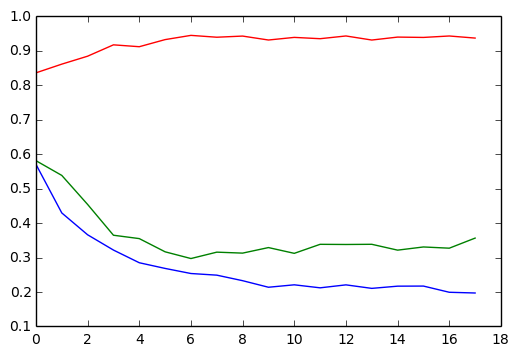

In [15]:
scaler, model = train(subject, create_dense, w, subsampling, batch_size)

In [16]:
print model.layers

from keras.utils.visualize_util import plot
plot(model, to_file='model.png')

[<keras.layers.core.Flatten object at 0x7ff0baa335d0>, <keras.layers.core.Dense object at 0x7ff0bc0e6110>, <keras.layers.core.Dense object at 0x7ff0bb7d3250>, <keras.layers.core.Activation object at 0x7ff0bb7f9990>]


In [17]:
proba = predict(subject, 8, w, subsampling, scaler, model)
truth = get_true_target(subject, 8)

In [18]:
from sklearn.metrics import roc_curve

print roc_auc_score( truth.values , proba.values, average = 'micro' )

info = []
for i in xrange(6):
    fpr, tpr, thresholds = roc_curve( truth.values[:,i] , proba.values[:,i] )
    fpr = fpr[1:]
    tpr = tpr[1:]
    thresholds = thresholds[1:]
    
    info.append( {'name':truth.columns[i], 'thresholds': thresholds, 'fpr': fpr, 'tpr': tpr} )

0.949644154225


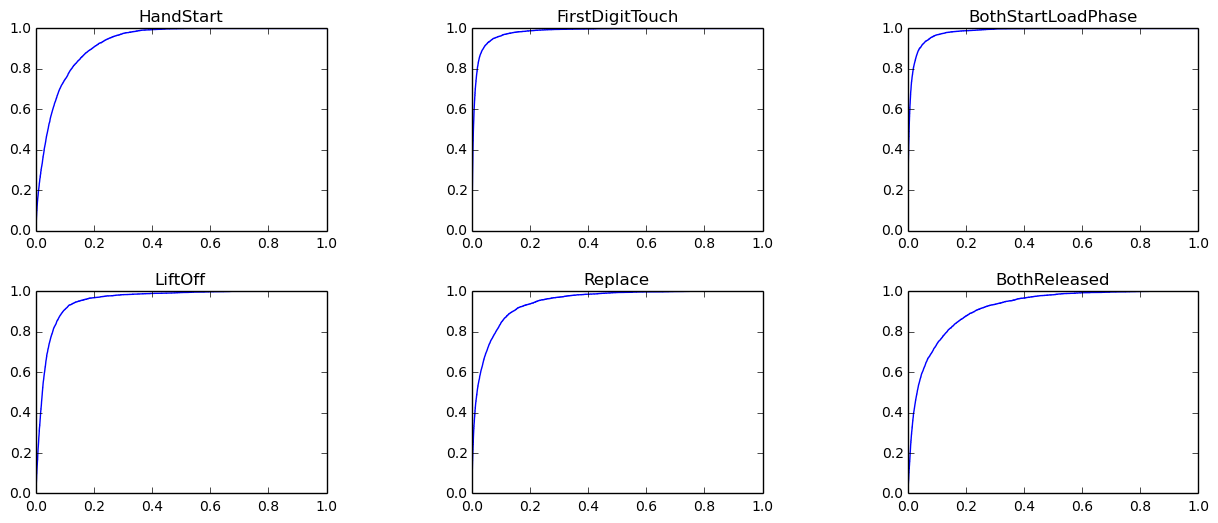

In [19]:
n_cols = 3
n_rows = 2

f,a = plt.subplots( nrows=n_rows, ncols=n_cols,figsize=(15, 3*n_rows) )
f.subplots_adjust(hspace = .3, wspace=.5)

iter_info = iter( info )
for i in xrange(n_rows):
    for j in xrange(n_cols):
        inf = next(iter_info, None)
        if not inf : break

        a[i,j].plot(inf['fpr'], inf['tpr'])
        a[i,j].set_title(inf['name'])

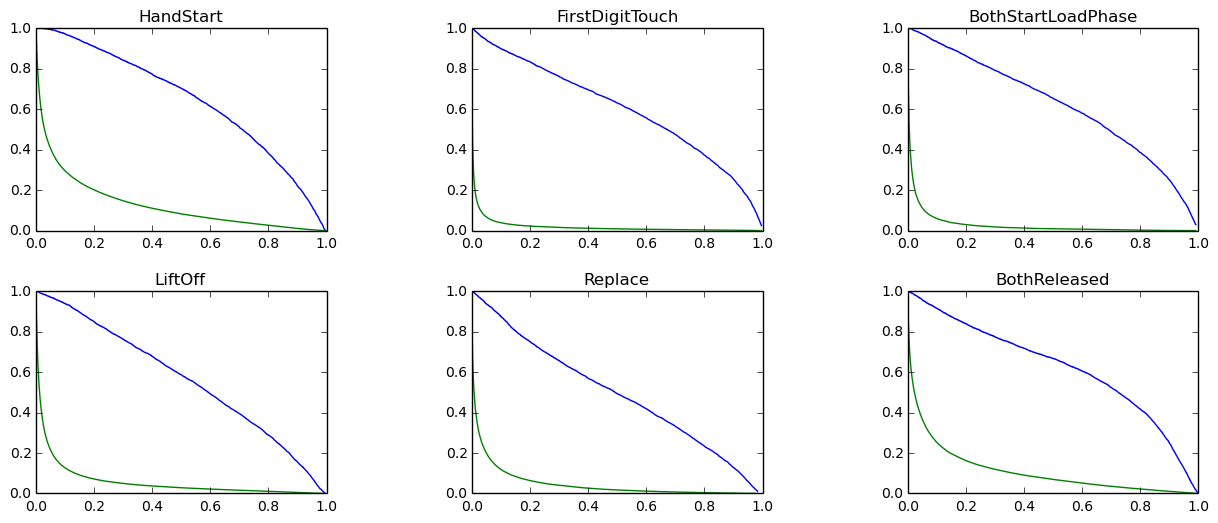

In [20]:
n_cols = 3
n_rows = 2

f,a = plt.subplots( nrows=n_rows, ncols=n_cols,figsize=(15, 3*n_rows) )
f.subplots_adjust(hspace = .3, wspace=.5)

iter_info = iter( info )
for i in xrange(n_rows):
    for j in xrange(n_cols):
        inf = next(iter_info, None)
        if not inf : break

        a[i,j].plot(inf['thresholds'], inf['tpr'])
        a[i,j].plot(inf['thresholds'], inf['fpr'])
        a[i,j].set_title(inf['name'])

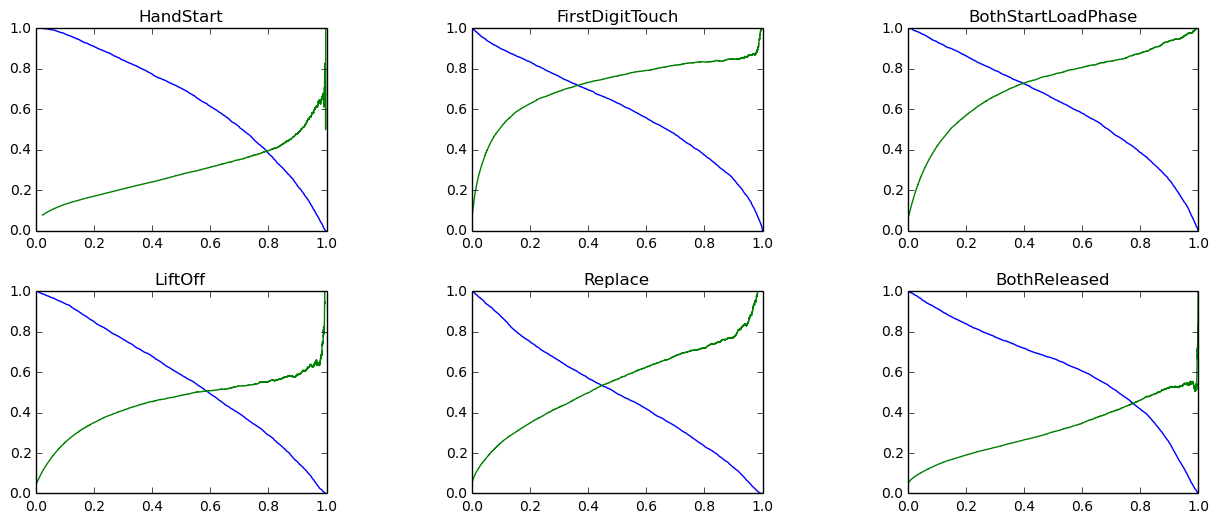

In [21]:
from sklearn.metrics import precision_recall_curve

info = []
for i in xrange(6):
    precision, recall, thresholds = precision_recall_curve( truth.values[:,i] , proba.values[:,i] )
    precision = precision[:-1]
    recall = recall[:-1]
    
    info.append( {'name':truth.columns[i], 'thresholds': thresholds, 'precision': precision, 'recall': recall} )
    
n_cols = 3
n_rows = 2

f,a = plt.subplots( nrows=n_rows, ncols=n_cols,figsize=(15, 3*n_rows) )
f.subplots_adjust(hspace = .3, wspace=.5)

iter_info = iter( info )
for i in xrange(n_rows):
    for j in xrange(n_cols):
        inf = next(iter_info, None)
        if not inf : break

        a[i,j].plot(inf['thresholds'], inf['recall'])
        a[i,j].plot(inf['thresholds'], inf['precision'])
        a[i,j].set_title(inf['name'])

In [22]:
pred = (proba > 0.9)

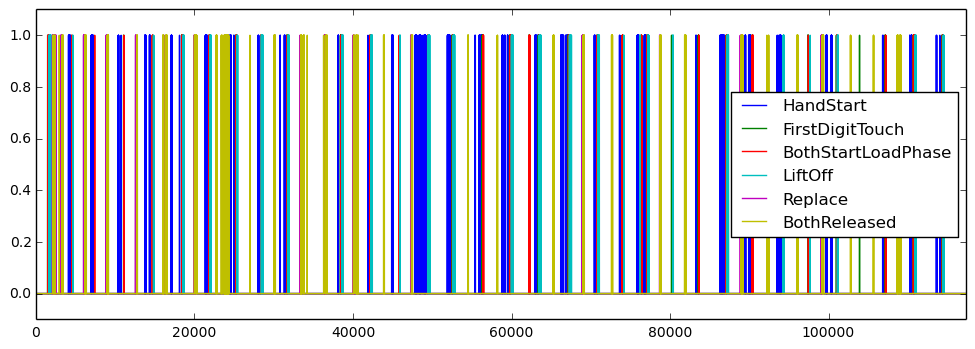

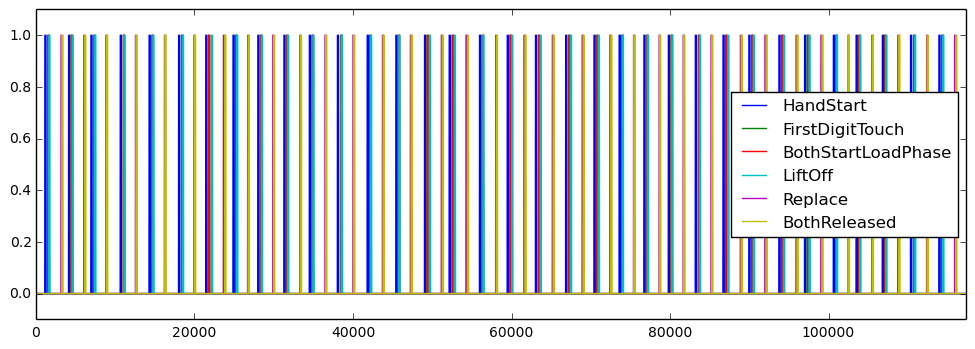

In [23]:
pred.plot(ylim = (-0.1, 1.1), figsize = (12, 4) )
truth.plot(ylim = (-0.1, 1.1), figsize = (12, 4) )

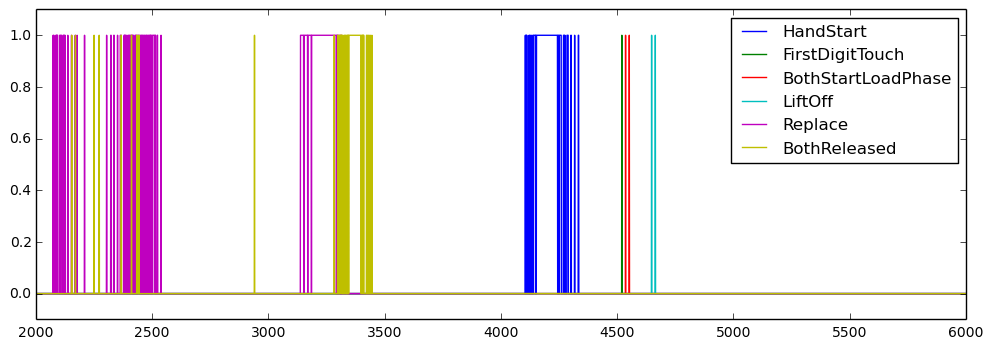

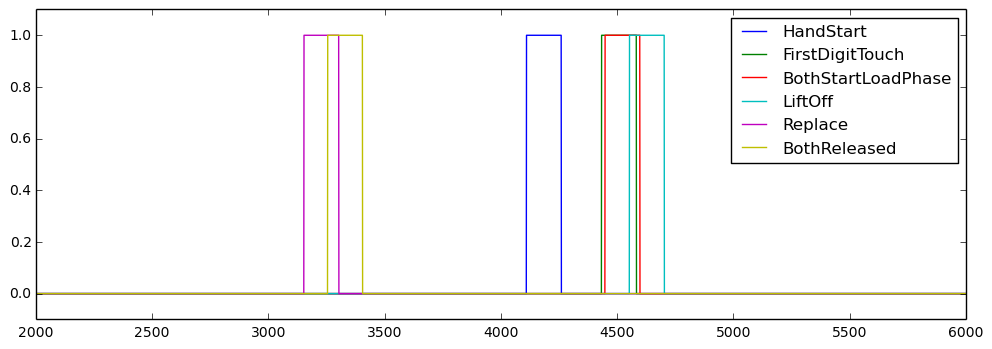

In [24]:
pred.plot(ylim = (-0.1, 1.1), figsize = (12, 4), xlim = (2000, 6000) )
truth.plot(ylim = (-0.1, 1.1), figsize = (12, 4), xlim = (2000, 6000) )